In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [2]:
import finding_data_sets

In [2]:
all_data = pd.read_csv("data/Daily m3 1315.csv")

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2596 entries, 0 to 2595
Columns: 1128 entries, property to 22/04/2015
dtypes: float64(1125), int64(2), object(1)
memory usage: 22.3+ MB


In [5]:
all_data.columns[-5:]

Index(['18/04/2015', '19/04/2015', '20/04/2015', '21/04/2015', '22/04/2015'], dtype='object')

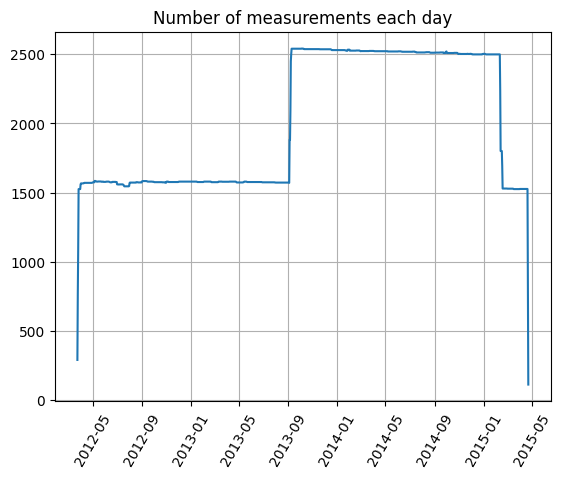

In [13]:
dates = pd.to_datetime(all_data.columns[3:], dayfirst=True)
plt.plot(dates, all_data.iloc[:, 3:].apply(lambda c: c.count(), axis=0))
plt.grid(True)
plt.title("Number of measurements each day")
plt.xticks(rotation=60)
plt.show()

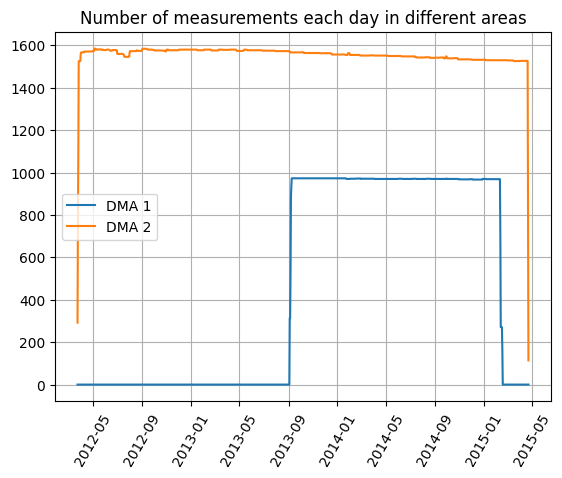

In [12]:
dma1 = all_data[all_data["DMA"] == 1]
dma2 = all_data[all_data["DMA"] == 2]
plt.plot(dates, dma1.iloc[:, 3:].apply(lambda c: c.count(), axis=0), label="DMA 1")
plt.plot(dates, dma2.iloc[:, 3:].apply(lambda c: c.count(), axis=0), label="DMA 2")
plt.grid(True)
plt.title("Number of measurements each day in different areas")
plt.xticks(rotation=60)
# plt.legend(loc="lower left")
plt.legend()
plt.show()

In [4]:
# df = pd.read_csv("data/Daily m3 1315.csv")

# 02/04/2012 to 20/04/2015
s = all_data.columns.get_loc("02/04/2012")
e = all_data.columns.get_loc("20/04/2015")
# s, e = finding_data_sets.find_col_indices(df, "02/04/2012", "20/04/2015")

cols = [0, 1, 2] + list(range(s, e + 1))
df = all_data.iloc[:, cols].dropna().copy()
df.drop("DMA", axis=1, inplace=True)
df = df.reset_index(drop=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Columns: 1116 entries, property to 20/04/2015
dtypes: float64(1114), int64(1), object(1)
memory usage: 12.4+ MB


In [6]:
df["meter location"].value_counts()

external    1220
internal     233
Name: meter location, dtype: int64

In [7]:
# dma1 = pd.read_csv("data/Daily m3 1315.csv")
dma1 = all_data[all_data["DMA"]  == 1]

# 09/09/2013 to 10/02/2015
s = dma1.columns.get_loc("09/09/2013")
e = dma1.columns.get_loc("10/02/2015")

cols = [0, 1, 2] + list(range(s, e + 1))
dma1 = dma1.iloc[:, cols].dropna()
dma1.drop("DMA", axis=1, inplace=True)
dma1 = dma1.reset_index(drop=True)

In [8]:
dma1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Columns: 522 entries, property to 10/02/2015
dtypes: float64(520), int64(1), object(1)
memory usage: 3.8+ MB


In [9]:
dma1["meter location"].value_counts()

external    690
internal    270
Name: meter location, dtype: int64

In [10]:
below_zeros = np.where(df.iloc[:, 2:].to_numpy() < 0)

In [11]:
for x, y in zip(below_zeros[0], below_zeros[1]):
    print(df.iloc[x, y+2], df.loc[x, "meter location"])
    df.iloc[x, y+2] = 0

-0.001 external
-0.794 external
-0.5 internal
-0.365 internal


In [12]:
means = df.iloc[:, 2:].mean(axis=1)
df.insert(2, "mean", means, True)

In [13]:
medians = df.iloc[:, 3:].median(axis=1)
df.insert(3, "median", medians, True)

In [14]:
# df.iloc[:10,:10]

In [15]:
def cluster(kulutusdata, klusterien_lkm, rng=1337, iter_lkm=420, use_log=False, log_offset=0.001):
    km = KMeans(n_clusters=klusterien_lkm, n_init="auto", max_iter=iter_lkm, random_state=rng)
    cols_to_drop = ["property", "meter location", "mean", "median"]
    tutkittava_data = kulutusdata.drop(cols_to_drop, axis=1)

    if use_log:
        tutkittava_data = np.log(tutkittava_data + log_offset)
    
    km.fit(tutkittava_data)

    col_name = "KMeans class" if not use_log else "KMeans class log"
    kulutusdata.insert(len(cols_to_drop), col_name, km.predict(tutkittava_data))

In [16]:
def show_clusters(dataframe, use_log=False):
    col_name = "KMeans class" if not use_log else "KMeans class log"
    groups = dataframe.groupby(col_name)
    # 
    show_df = pd.concat([groups["mean"].count(), groups["mean"].min().round(3), groups["mean"].max().round(3), groups["median"].min(), groups["median"].max()], axis=1)
    show_df.columns = ["count", "min mean", "max mean", "min median", "max median"]
    show_df = show_df.sort_values("min mean")

    print(show_df)

In [17]:
cluster(df, 14)
show_clusters(df)

              count  min mean  max mean  min median  max median
KMeans class                                                   
0               344     0.000     0.152      0.0000      0.1560
11              408     0.149     0.255      0.0970      0.2990
13                2     0.210     0.217      0.1600      0.1650
9               334     0.249     0.390      0.0000      0.3870
10              232     0.356     0.531      0.2975      0.5270
5                93     0.502     0.771      0.1560      0.7920
3                30     0.760     1.531      0.5435      1.4005
6                 1     1.437     1.437      0.9345      0.9345
4                 1     1.443     1.443      0.3280      0.3280
7                 3     1.968     2.249      2.1135      2.2420
8                 2     2.556     3.226      2.4090      2.8450
12                1     4.137     4.137      4.1385      4.1385
2                 1    11.183    11.183      0.5700      0.5700
1                 1    37.940    37.940 

In [18]:
cluster(df, 14, use_log=True)
show_clusters(df, use_log=True)

                  count  min mean  max mean  min median  max median
KMeans class log                                                   
11                   23     0.000     0.338      0.0000      0.0475
5                    46     0.017     0.227      0.0035      0.2435
6                   255     0.048     0.273      0.0400      0.3220
7                    25     0.064     0.393      0.0660      0.3860
10                   21     0.069     0.305      0.0680      0.3280
2                     1     0.070     0.070      0.0680      0.0680
13                   10     0.092     0.382      0.0980      0.3175
8                     7     0.100     0.211      0.0985      0.2470
0                    24     0.116     0.516      0.0565      0.3650
9                   434     0.121     0.383      0.0970      0.3820
12                    2     0.145     0.147      0.1530      0.1550
4                   472     0.233     1.443      0.1560      0.5670
3                     1     0.240     0.240     

In [19]:
cluster

<function __main__.cluster(kulutusdata, klusterien_lkm, rng=1337, iter_lkm=420, use_log=False, log_offset=0.001)>

In [20]:
below_zeros1 = np.where(dma1.iloc[:, 2:].to_numpy() < 0)
below_zeros1

(array([181], dtype=int64), array([55], dtype=int64))

In [21]:
for x, y in zip(below_zeros1[0], below_zeros1[1]):
    print(dma1.iloc[x, y+2], dma1.loc[x, "meter location"])
    dma1.iloc[x, y+2] = 0

-0.167 internal


In [22]:
means = dma1.iloc[:, 2:].mean(axis=1)
dma1.insert(2, "mean", means, True)

In [23]:
means = dma1.iloc[:, 3:].mean(axis=1)
dma1.insert(3, "median", means, True)

In [24]:
dma1.iloc[:10, :10]

,property,meter location,mean,median,09/09/2013,10/09/2013,11/09/2013,12/09/2013,13/09/2013,14/09/2013
0,1,external,0.133842,0.133842,0.144,0.145,0.160,0.100,0.154,0.110
1,1,internal,0.083254,0.083254,0.108,0.108,0.107,0.035,0.079,0.042
2,2,external,0.289156,0.289156,0.285,0.202,0.178,0.217,0.278,0.421
3,3,external,0.208904,0.208904,0.148,0.274,0.142,0.271,0.359,0.339
4,4,internal,0.135765,0.135765,0.040,0.112,0.073,0.047,0.091,0.055
5,5,external,0.368262,0.368262,0.498,0.373,0.338,0.235,0.448,0.214
6,6,external,0.132106,0.132106,0.208,0.176,0.126,0.256,0.087,0.107
7,6,internal,0.130967,0.130967,0.207,0.174,0.125,0.254,0.086,0.106
8,7,external,0.550437,0.550437,0.539,0.487,0.825,0.617,0.358,0.602
9,8,external,0.456040,0.456040,0.343,0.306,0.529,0.379,0.511,0.506


In [25]:
cluster(dma1, 12)
show_clusters(dma1)

              count  min mean  max mean  min median  max median
KMeans class                                                   
3               590     0.000     0.236    0.000133    0.236198
10              301     0.235     0.506    0.234981    0.505950
0                 1     0.394     0.394    0.394162    0.394162
5                57     0.422     1.357    0.421765    1.356977
8                 2     1.944     1.961    1.944098    1.961027
11                1     3.247     3.247    3.246556    3.246556
7                 3     3.798     4.340    3.798162    4.340038
9                 1     4.013     4.013    4.013229    4.013229
4                 1     5.380     5.380    5.379556    5.379556
6                 1     6.536     6.536    6.535625    6.535625
2                 1    25.205    25.205   25.204821   25.204821
1                 1   454.595   454.595  454.595040  454.595040


In [26]:
cluster(dma1, 12, use_log=True)
show_clusters(dma1, use_log=True)

                  count  min mean  max mean  min median  max median
KMeans class log                                                   
5                    17     0.000     0.073    0.000133    0.073408
1                    43     0.023     0.201    0.023079    0.201448
2                   120     0.033     0.240    0.033023    0.239971
9                    10     0.040     0.181    0.039744    0.181213
10                    8     0.052     0.450    0.051835    0.450442
4                    20     0.061     0.259    0.060577    0.258835
3                   207     0.079     0.422    0.079483    0.421765
8                     3     0.107     0.109    0.106742    0.108973
11                  277     0.134     0.567    0.133842    0.567167
7                   237     0.254    25.205    0.253588   25.204821
0                     1     0.394     0.394    0.394162    0.394162
6                    17     0.951   454.595    0.951212  454.595040


In [27]:
big_consumption = dma1[dma1["KMeans class"] == 1]
# big_consumption[:15]
big_consumption = big_consumption.iloc[0, 4:]

In [28]:
all_data[all_data["property"] == 163]

,property,meter location,DMA,24/03/2012,25/03/2012,26/03/2012,27/03/2012,28/03/2012,29/03/2012,30/03/2012,...,13/04/2015,14/04/2015,15/04/2015,16/04/2015,17/04/2015,18/04/2015,19/04/2015,20/04/2015,21/04/2015,22/04/2015
197,163,external,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
big_consumption = df[df["KMeans class"] == 1].iloc[0, 4:]
not_quite_so_big_consumption = df[df["KMeans class"] == 2].iloc[0, 4:]

In [30]:
small_part = big_consumption[big_consumption < 1]
len(small_part)

317

In [31]:
small_part.max()

0.99

In [32]:
small_part = not_quite_so_big_consumption[not_quite_so_big_consumption < 2]
len(small_part)

589

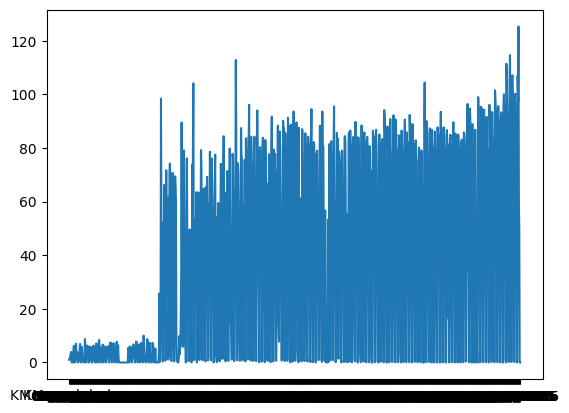

In [33]:
plt.plot(big_consumption)

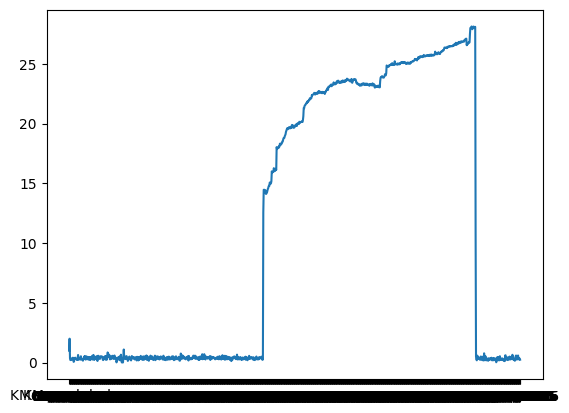

In [34]:
plt.plot(not_quite_so_big_consumption)